In [864]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [865]:
import pandas as pd
import matplotlib as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import shap
from sklearn.inspection import permutation_importance

In [866]:
# load the initial labeled data:
initial_data = pd.read_csv("02 CHDdata-sample-to-start-with.csv")
# load the unlabeled data:
unlabeled_data = pd.read_csv("03 CHDdata-unlabelled-nolabels.csv", sep=';')
orderlist = unlabeled_data.copy()

In [867]:
#getting an overview over what the data looks like
initial_data.head(10)


,chd,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age
0,0,143,5.04,4.86,23.59,Absent,58,24.69,18.72,42
1,1,136,2.52,3.95,25.63,Absent,51,21.86,0.00,45
2,1,136,11.20,5.81,31.85,Present,75,27.68,22.94,58
3,0,144,2.40,8.13,35.61,Absent,46,27.38,13.37,60
4,0,153,7.80,3.96,25.73,Absent,54,25.91,27.03,45
5,0,128,0.73,3.97,23.52,Absent,54,23.81,19.20,64
6,0,132,0.00,4.17,36.57,Absent,57,30.61,18.00,49
7,1,122,1.00,5.88,34.81,Present,69,31.27,15.94,40
8,0,170,0.40,4.11,42.06,Present,56,33.10,2.06,57
9,1,140,0.60,5.56,33.39,Present,58,27.19,0.00,55


In [868]:
# preparing the data for XGBoost
initial_data.loc[initial_data["famhist"] == "Absent", "famhist"] = 0
initial_data.loc[initial_data["famhist"] == "Present", "famhist"] = 1
initial_data['famhist'] = initial_data['famhist'].astype(int)
initial_data.head(10)



,chd,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age
0,0,143,5.04,4.86,23.59,0,58,24.69,18.72,42
1,1,136,2.52,3.95,25.63,0,51,21.86,0.00,45
2,1,136,11.20,5.81,31.85,1,75,27.68,22.94,58
3,0,144,2.40,8.13,35.61,0,46,27.38,13.37,60
4,0,153,7.80,3.96,25.73,0,54,25.91,27.03,45
5,0,128,0.73,3.97,23.52,0,54,23.81,19.20,64
6,0,132,0.00,4.17,36.57,0,57,30.61,18.00,49
7,1,122,1.00,5.88,34.81,1,69,31.27,15.94,40
8,0,170,0.40,4.11,42.06,1,56,33.10,2.06,57
9,1,140,0.60,5.56,33.39,1,58,27.19,0.00,55


<Axes: >

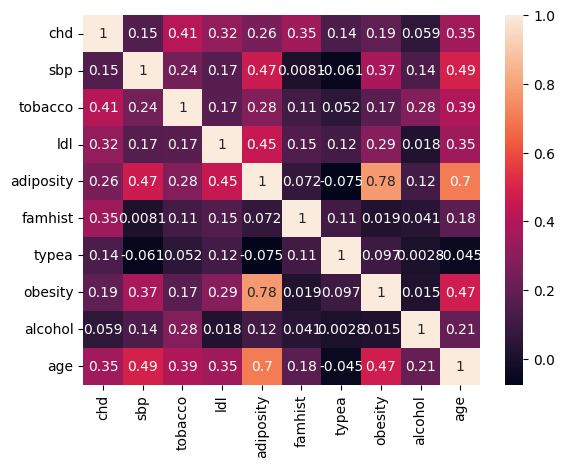

In [869]:
#heatmap of correlations to see whether features are correlated
sns.heatmap(initial_data.corr(), annot= True)

### Train / Test Split

In [870]:
X = initial_data.drop('chd', axis=1)  # Features
y = initial_data['chd']               # Target

#performing train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Initial Model

In [871]:
#fitting XGB Model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# predictions for test set
test_predictions = model.predict(X_test)


#Calculating accuracy
accuracy_test = accuracy_score(y_test, test_predictions)

print(f"Test accuracy: {accuracy_test}")

Test accuracy: 0.7368421052631579


In [872]:
# printing the classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=['Absent', 'Present']))



Classification Report:
              precision    recall  f1-score   support

      Absent       0.75      0.82      0.78        11
     Present       0.71      0.62      0.67         8

    accuracy                           0.74        19
   macro avg       0.73      0.72      0.72        19
weighted avg       0.73      0.74      0.73        19



### SHAP Summary Plot

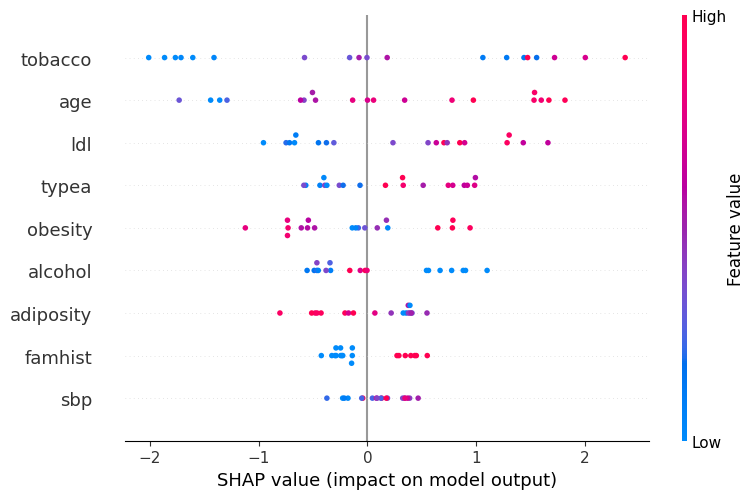

In [873]:
explainer = shap.Explainer(model, X_train)  

# Calculate SHAP values for the test set
shap_values = explainer(X_test)  

shap.summary_plot(shap_values, X_test)

### Permutation Feature Importance

In [874]:
# Calculate permutation feature importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Sort features by importance
sorted_idx = result.importances_mean.argsort()

# Print feature importance
for i in sorted_idx[::-1]:
    print(f"{X_test.columns[i]:<30}"
          f"{result.importances_mean[i]:.3f}"
          f" ± {result.importances_std[i]:.3f}")



tobacco                       0.126 ± 0.067
famhist                       0.063 ± 0.046
obesity                       0.058 ± 0.037
age                           0.058 ± 0.072
alcohol                       0.037 ± 0.024
ldl                           0.011 ± 0.032
adiposity                     0.000 ± 0.000
sbp                           0.000 ± 0.000
typea                         -0.021 ± 0.035


### Prediction Probabilities

In [875]:
# Predicting probabilities for both the training and test sets
train_probs = model.predict_proba(X)[:, 1]  # Probability of positive class


# Including these probabilities and actual labels in the DataFrames
X['CHD_Probability'] = train_probs
X['chd'] = y.reset_index(drop=True)  # Ensure alignment



# If you want to analyze the performance further, you can, for example,
# inspect cases where the model was highly uncertain:
uncertain_cases = X[(X['CHD_Probability'] > 0.20) & (X['CHD_Probability'] < 0.8)]
uncertain_cases['Actual CHD'] = initial_data['chd']
print(uncertain_cases)
print("Uncertain cases in set:", uncertain_cases.shape[0])



    sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  \
0   143     5.04  4.86      23.59        0     58    24.69    18.72   42   
4   153     7.80  3.96      25.73        0     54    25.91    27.03   45   
12  134     0.00  5.90      30.84        0     49    29.16     0.00   55   
28  158     2.60  7.46      34.07        1     61    29.30    53.28   62   

    CHD_Probability  chd  Actual CHD  
0          0.484314    0           0  
4          0.306798    0           0  
12         0.456045    0           0  
28         0.798358    1           1  
Uncertain cases in set: 4


/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_38996/3849838848.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncertain_cases['Actual CHD'] = initial_data['chd']


### Finding Misclassifications

In [876]:
initial_data_with_predictions = initial_data.copy()

# excluding any target variable
X_initial = initial_data.drop(columns=['chd'], errors='ignore')

initial_predictions = model.predict(X_initial)  
initial_predictions_probabilities = model.predict_proba(X_initial)[:,1]  
# adding the predictions & Actual CHD as new columns to `initial_data`
initial_data_with_predictions['Actual CHD'] = initial_data['chd']
initial_data_with_predictions['Prediction'] = initial_predictions
initial_data_with_predictions['Probability'] = initial_predictions_probabilities


In [919]:
# Identifying misclassified instances
misclassified= initial_data_with_predictions[initial_data_with_predictions["Actual CHD"] != initial_data_with_predictions["Prediction"]]
print("Misclassified instances: ")
misclassified

Misclassified instances: 


,chd,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,Actual CHD,Prediction,Probability
18,0,174,9.45,5.13,35.54,0,55,30.71,59.79,53,0,1,0.970697
40,0,136,1.70,3.53,20.13,0,56,19.44,14.40,55,0,1,0.876631
44,1,122,4.40,3.18,11.59,1,59,21.94,0.00,33,1,0,0.199559
49,1,134,1.50,3.73,21.53,0,41,24.70,11.11,30,1,0,0.041123
55,1,134,10.00,3.79,34.72,0,42,28.33,28.80,52,1,0,0.098069


In [878]:
false_positives = misclassified[misclassified['Actual CHD']== 0]
false_negatives = misclassified[misclassified['Actual CHD']== 1]

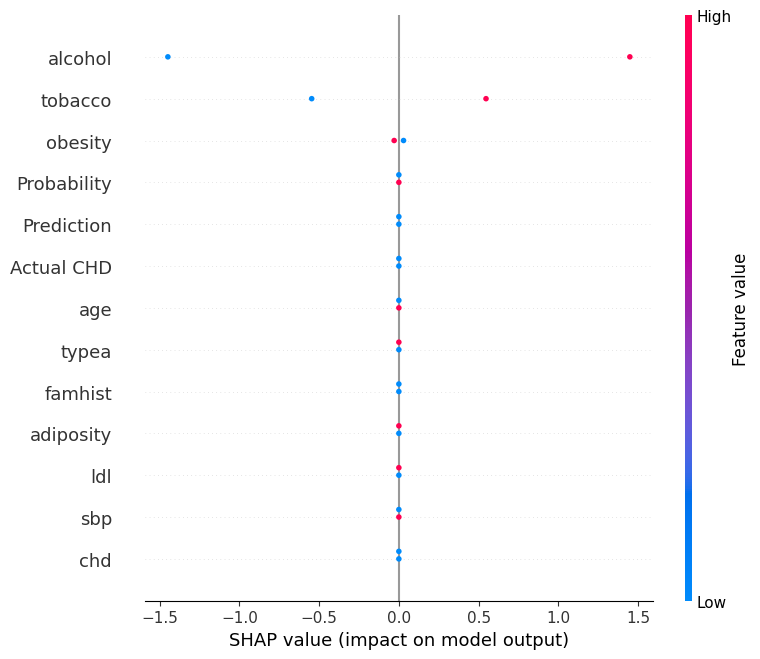

In [879]:
#SHAP Summary Plot

explainer = shap.Explainer(model, false_positives)  

# Calculate SHAP values for the test set
shap_values = explainer(false_positives)  

shap.summary_plot(shap_values, false_positives)

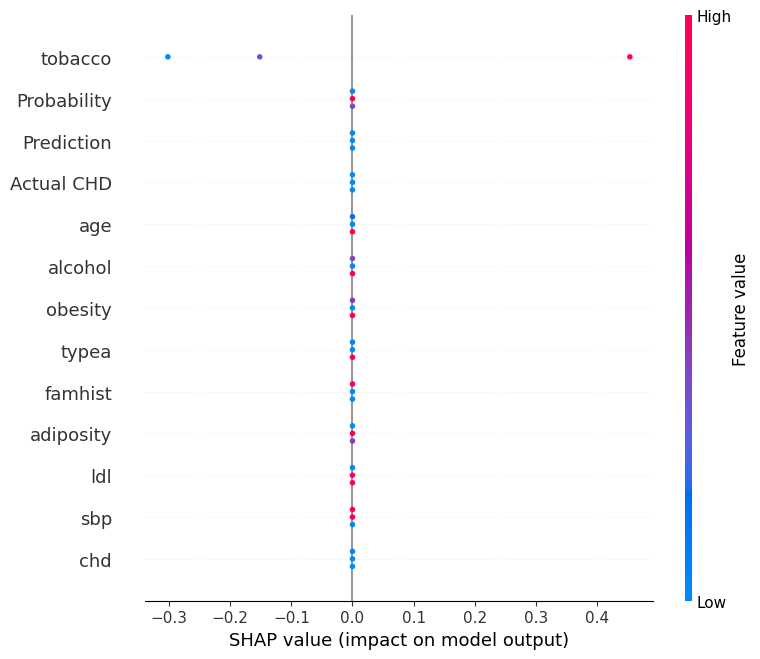

In [880]:
#SHAP Summary Plot

explainer = shap.Explainer(model, false_negatives)  

# Calculate SHAP values for the test set
shap_values = explainer(false_negatives)  

shap.summary_plot(shap_values, false_negatives)

In [881]:
initial_data_with_predictions.describe()


,chd,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,Actual CHD,Prediction,Probability
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,0.365591,139.720430,3.900538,4.700323,26.578817,0.419355,52.129032,26.030323,23.816344,42.978495,0.365591,0.354839,0.367031
std,0.484206,21.446782,4.841627,1.892926,8.433918,0.496128,9.110703,3.856828,31.856970,14.056546,0.484206,0.481058,0.424641
min,0.000000,101.000000,0.000000,1.070000,7.120000,0.000000,31.000000,17.750000,0.000000,15.000000,0.000000,0.000000,0.001174
25%,0.000000,126.000000,0.090000,3.370000,21.530000,0.000000,45.000000,23.330000,0.600000,33.000000,0.000000,0.000000,0.010947
50%,0.000000,134.000000,2.000000,4.170000,27.140000,0.000000,52.000000,25.800000,10.490000,46.000000,0.000000,0.000000,0.084266
75%,1.000000,150.000000,5.500000,5.910000,34.020000,1.000000,58.000000,28.710000,36.000000,54.000000,1.000000,1.000000,0.890669
max,1.000000,218.000000,25.010000,12.420000,42.170000,1.000000,75.000000,35.070000,145.290000,64.000000,1.000000,1.000000,0.997322


In [882]:
false_positives

,chd,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,Actual CHD,Prediction,Probability
18,0,174,9.45,5.13,35.54,0,55,30.71,59.79,53,0,1,0.970697
40,0,136,1.70,3.53,20.13,0,56,19.44,14.40,55,0,1,0.876631


In [883]:
false_negatives

,chd,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,Actual CHD,Prediction,Probability
44,1,122,4.4,3.18,11.59,1,59,21.94,0.00,33,1,0,0.199559
49,1,134,1.5,3.73,21.53,0,41,24.70,11.11,30,1,0,0.041123
55,1,134,10.0,3.79,34.72,0,42,28.33,28.80,52,1,0,0.098069


In [884]:
uncertain_cases

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,CHD_Probability,chd,Actual CHD
0,143,5.04,4.86,23.59,0,58,24.69,18.72,42,0.484314,0,0
4,153,7.80,3.96,25.73,0,54,25.91,27.03,45,0.306798,0,0
12,134,0.00,5.90,30.84,0,49,29.16,0.00,55,0.456045,0,0
28,158,2.60,7.46,34.07,1,61,29.30,53.28,62,0.798358,1,1


## Learning a second model without the TypeA Column

In [885]:
X_without_typea = initial_data.drop(['chd', 'typea'], axis=1)  # Features
y_without_typea = initial_data['chd']               # Target

#performing train test split
X_train_without_typea, X_test_without_typea, y_train_without_typea, y_test_without_typea = train_test_split(X_without_typea, y_without_typea, test_size=0.2, random_state=42)

In [886]:
#fitting XGB Model
model_without_typea = xgb.XGBClassifier()
model_without_typea.fit(X_train_without_typea, y_train_without_typea)

# predictions for test set
test_predictions_without_typea = model_without_typea.predict(X_test_without_typea)


#Calculating accuracy
accuracy_test_without_typea = accuracy_score(y_test_without_typea, test_predictions_without_typea)

print(f"Test accuracy: {accuracy_test_without_typea}")

Test accuracy: 0.7368421052631579


In [887]:
# printing the classification report
print("\nClassification Report:")
print(classification_report(y_test_without_typea, test_predictions_without_typea, target_names=['Absent', 'Present']))



Classification Report:
              precision    recall  f1-score   support

      Absent       0.75      0.82      0.78        11
     Present       0.71      0.62      0.67         8

    accuracy                           0.74        19
   macro avg       0.73      0.72      0.72        19
weighted avg       0.73      0.74      0.73        19



Conclusion: Type A column does not have enough effect to change anything about the predictions!

## Part II: Trying to find the best 50 instances in the unlabeled data

In [888]:
unlabeled_data.head()

,Nr,chd,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,request_label
0,1,NaN,112,0.41,1.88,10.29,Absent,39,22.08,20.98,27,NaN
1,2,NaN,158,4.00,4.18,28.61,Present,42,25.11,0.00,60,NaN
2,3,NaN,132,0.72,4.37,19.54,Absent,48,26.11,49.37,28,NaN
3,4,NaN,136,1.36,3.16,14.97,Present,56,24.98,7.30,24,NaN
4,5,NaN,140,8.60,3.90,32.16,Present,52,28.51,11.11,64,NaN


In [889]:
# preparing the unlabeled data for XGBoost -> same as previously with labeled data
unlabeled_data.loc[unlabeled_data["famhist"] == "Absent", "famhist"] = 0
unlabeled_data.loc[unlabeled_data["famhist"] == "Present", "famhist"] = 1
unlabeled_data['famhist'] = unlabeled_data['famhist'].astype(int)
unlabeled_data.head(10)



,Nr,chd,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,request_label
0,1,NaN,112,0.41,1.88,10.29,0,39,22.08,20.98,27,NaN
1,2,NaN,158,4.00,4.18,28.61,1,42,25.11,0.00,60,NaN
2,3,NaN,132,0.72,4.37,19.54,0,48,26.11,49.37,28,NaN
3,4,NaN,136,1.36,3.16,14.97,1,56,24.98,7.30,24,NaN
4,5,NaN,140,8.60,3.90,32.16,1,52,28.51,11.11,64,NaN
5,6,NaN,108,0.80,2.47,17.53,0,47,22.18,0.00,55,NaN
6,7,NaN,134,0.12,3.40,21.18,1,33,26.27,14.21,30,NaN
7,8,NaN,144,0.00,4.17,29.63,1,52,21.83,0.00,59,NaN
8,9,NaN,123,8.60,11.17,35.28,1,70,33.14,0.00,59,NaN
9,10,NaN,118,1.05,3.16,12.98,1,46,22.09,16.35,31,NaN


In [890]:
unlabeled_data_with_predictions = unlabeled_data.copy().drop(['chd', 'request_label', 'Nr'], axis = 1)

unlabeled_predictions = model.predict(unlabeled_data_with_predictions)  
unlabeled_predictions_probabilities = model.predict_proba(unlabeled_data_with_predictions)[:,1]  
# adding the predictions & Actual CHD as new columns to `initial_data`

unlabeled_data_with_predictions['Prediction'] = unlabeled_predictions
unlabeled_data_with_predictions['Probability'] = unlabeled_predictions_probabilities


In [891]:
uncertain_unlabeled_cases = unlabeled_data_with_predictions[(unlabeled_data_with_predictions['Probability'] > 0.38) & (unlabeled_data_with_predictions['Probability'] < 0.78)]

In [892]:
uncertain_unlabeled_cases["Nr"] = uncertain_unlabeled_cases.index + 1

/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_38996/1295751148.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncertain_unlabeled_cases["Nr"] = uncertain_unlabeled_cases.index + 1


In [893]:
print("Uncertain cases in unlabeled set:", uncertain_unlabeled_cases.shape[0])

Uncertain cases in unlabeled set: 50


In [894]:

merged_data = pd.merge(unlabeled_data, uncertain_unlabeled_cases['Nr'], on='Nr', how='left')

# Set 'request_label' to 1 for instances present in uncertain_unlabeled_cases and 0 for all others
merged_data['request_label'] = merged_data['Nr'].apply(lambda x: "yes" if x in uncertain_unlabeled_cases['Nr'].values else "no")

# Now merged_data contains the 'request_label' column updated as per your requirement


In [895]:
merged_data[merged_data['request_label']== "yes"]

,Nr,chd,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,request_label
10,11,NaN,176,1.20,8.28,36.16,1,42,27.81,11.60,58,yes
17,18,NaN,160,1.15,10.19,39.71,0,31,31.65,20.52,57,yes
19,20,NaN,108,3.00,1.59,15.23,0,40,20.09,26.64,55,yes
25,26,NaN,108,15.00,4.91,34.65,0,41,27.96,14.40,56,yes
27,28,NaN,162,1.50,2.46,19.39,1,49,24.32,0.00,59,yes
34,35,NaN,116,2.70,3.69,13.52,0,55,21.13,18.51,32,yes
35,36,NaN,162,2.92,3.63,31.33,0,62,31.59,18.51,42,yes
39,40,NaN,128,2.00,6.13,21.31,0,66,22.86,11.83,60,yes
41,42,NaN,132,7.28,3.52,12.33,0,60,19.48,2.06,56,yes
42,43,NaN,128,5.16,4.90,31.35,1,57,26.42,0.00,64,yes


## With 50 additional requested labels

In [896]:
csv_file_path = 'label_requests.csv'

# Write the DataFrame to a CSV file
merged_data.to_csv(csv_file_path, index=False)

print(f"DataFrame successfully saved to {csv_file_path}")

DataFrame successfully saved to label_requests.csv


In [897]:
requested_labels = pd.read_excel('Labels-Group1-2.xlsx')  

In [898]:
requested_labels.drop('request', axis=1)

,chd,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age
0,1,176,1.20,8.28,36.16,Present,42,27.81,11.60,58
1,0,160,1.15,10.19,39.71,Absent,31,31.65,20.52,57
2,0,108,3.00,1.59,15.23,Absent,40,20.09,26.64,55
3,0,108,15.00,4.91,34.65,Absent,41,27.96,14.40,56
4,1,162,1.50,2.46,19.39,Present,49,24.32,0.00,59
5,0,116,2.70,3.69,13.52,Absent,55,21.13,18.51,32
6,0,162,2.92,3.63,31.33,Absent,62,31.59,18.51,42
7,0,128,2.00,6.13,21.31,Absent,66,22.86,11.83,60
8,0,132,7.28,3.52,12.33,Absent,60,19.48,2.06,56
9,0,128,5.16,4.90,31.35,Present,57,26.42,0.00,64


In [899]:
# preparing the unlabeled data for XGBoost -> same as previously with labeled data
requested_labels.loc[requested_labels["famhist"] == "Absent", "famhist"] = 0
requested_labels.loc[requested_labels["famhist"] == "Present", "famhist"] = 1
requested_labels['famhist'] = requested_labels['famhist'].astype(int)



In [900]:
requested_labels.head()

,chd,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,request
0,1,176,1.20,8.28,36.16,1,42,27.81,11.60,58,yes
1,0,160,1.15,10.19,39.71,0,31,31.65,20.52,57,yes
2,0,108,3.00,1.59,15.23,0,40,20.09,26.64,55,yes
3,0,108,15.00,4.91,34.65,0,41,27.96,14.40,56,yes
4,1,162,1.50,2.46,19.39,1,49,24.32,0.00,59,yes


Combining the initial data with the 50 requested instances in one df to use for the model.

In [901]:
df_including_requested = pd.concat([initial_data, requested_labels], axis=0, ignore_index=True)
df_including_requested.drop('request', axis=1)

,chd,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age
0,0,143,5.04,4.86,23.59,0,58,24.69,18.72,42
1,1,136,2.52,3.95,25.63,0,51,21.86,0.00,45
2,1,136,11.20,5.81,31.85,1,75,27.68,22.94,58
3,0,144,2.40,8.13,35.61,0,46,27.38,13.37,60
4,0,153,7.80,3.96,25.73,0,54,25.91,27.03,45
...,...,...,...,...,...,...,...,...,...,...
138,1,128,0.70,4.90,37.42,1,72,35.94,3.09,49
139,0,142,2.40,2.55,23.89,0,54,26.09,59.14,37
140,0,128,6.60,3.58,20.71,0,55,24.15,0.00,52
141,0,164,12.00,3.91,19.59,0,51,23.44,19.75,39


### Train / Test Split

In [902]:
X_full = df_including_requested.drop('chd', axis=1)  # Features
y_full = df_including_requested['chd']               # Target

#performing train test split
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

## Test Set

In [904]:
df_including_requested.drop('request', axis=1, inplace=True)

In [905]:
X_full = df_including_requested.drop('chd', axis=1)  # Features
y_full = df_including_requested['chd']               # Target


In [906]:
test_data = pd.read_csv("04 CHDdata-overall-test-set.csv", delimiter=";")


In [907]:
test_data.loc[test_data["famhist"] == "Absent", "famhist"] = 0
test_data.loc[test_data["famhist"] == "Present", "famhist"] = 1
test_data['famhist'] = test_data['famhist'].astype(int)

In [908]:
X_test_full = test_data.drop('chd', axis=1)  # Features
y_test_full = test_data['chd']   

In [909]:
X_test


,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age
40,136,1.70,3.53,20.13,0,56,19.44,14.40,55
22,114,0.00,2.63,9.69,0,45,17.89,0.00,16
55,134,10.00,3.79,34.72,0,42,28.33,28.80,52
72,101,0.48,7.26,13.00,0,50,19.82,5.19,16
0,143,5.04,4.86,23.59,0,58,24.69,18.72,42
26,124,0.00,4.79,34.71,0,49,26.09,9.26,47
39,108,0.40,5.91,22.92,1,57,25.72,72.00,39
67,124,14.00,6.23,35.96,1,45,30.09,0.00,59
10,124,1.60,7.22,39.68,1,36,31.50,0.00,51
44,122,4.40,3.18,11.59,1,59,21.94,0.00,33


## Original Model on Test Set

In [917]:
#fitting XGB Model
model_full = xgb.XGBClassifier()
model_full.fit(X_train, y_train)

# predictions for test set
test_predictions_full_original = model_full.predict(X_test_full)


#Calculating accuracy
accuracy_test_full_original = accuracy_score(y_test_full, test_predictions_full_original)

print(f"Test accuracy: {accuracy_test_full_original}")

Test accuracy: 0.7019867549668874


In [918]:
# printing the classification report
print("\nClassification Report:")
print(classification_report(y_test_full, test_predictions_full_original, target_names=['Absent', 'Present']))


Classification Report:
              precision    recall  f1-score   support

      Absent       0.75      0.82      0.78        98
     Present       0.59      0.49      0.54        53

    accuracy                           0.70       151
   macro avg       0.67      0.65      0.66       151
weighted avg       0.69      0.70      0.69       151



In [912]:
#fitting XGB Model
model_full = xgb.XGBClassifier()
model_full.fit(X_full, y_full)

# predictions for test set
test_predictions_full = model_full.predict(X_test_full)


#Calculating accuracy
accuracy_test_full = accuracy_score(y_test_full, test_predictions_full)

print(f"Test accuracy model with additional 50 labels: {accuracy_test_full}")

Test accuracy model with additional 50 labels: 0.695364238410596


In [915]:
# printing the classification report
print("\nClassification Report:")
print(classification_report(y_test_full, test_predictions_full, target_names=['Absent', 'Present']))


Classification Report:
              precision    recall  f1-score   support

      Absent       0.75      0.79      0.77        98
     Present       0.57      0.53      0.55        53

    accuracy                           0.70       151
   macro avg       0.66      0.66      0.66       151
weighted avg       0.69      0.70      0.69       151

